<a href="https://colab.research.google.com/github/Emmanuelprz1400/classifier-reviews-with-RNN/blob/main/review_hotels_with_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cargar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim  # para cargar modelo w2v
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gensim.parsing.preprocessing as gpp


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

# 1. Exploración de los datos

In [ ]:
csv_file ="https://raw.githubusercontent.com/AnIsAsPe/LogisticRegression_SpamOpinion/master/Datos/deceptive-opinion.csv"
data = pd.read_csv(csv_file, encoding= 'unicode_escape', usecols =[2,4])
data = data.fillna( method='ffill', axis=0)
data.head()

,polarity,text
0,positive,We stayed for a one night getaway with family ...
1,positive,Triple A rate with upgrade to view room was le...
2,positive,This comes a little late as I'm finally catchi...
3,positive,The Omni Chicago really delivers on all fronts...
4,positive,I asked for a high floor away from the elevato...


In [ ]:
data.loc[:50]

,polarity,text
0,positive,We stayed for a one night getaway with family ...
1,positive,Triple A rate with upgrade to view room was le...
2,positive,This comes a little late as I'm finally catchi...
3,positive,The Omni Chicago really delivers on all fronts...
4,positive,I asked for a high floor away from the elevato...
5,positive,I stayed at the Omni for one night following a...
6,positive,We stayed in the Conrad for 4 nights just befo...
7,positive,Just got back from 2 days up in Chicago shoppi...
8,positive,We arrived at the Omni on 2nd September for a ...
9,positive,"On our visit to Chicago, we chose the Hyatt du..."


In [ ]:
data.nunique()  # Valores únicos en cada columna

polarity       2
text        1596
dtype: int64

In [ ]:
data.polarity.value_counts()

polarity
positive    800
negative    800
Name: count, dtype: int64

# 2. Preprocesamiento de texto

In [ ]:
def preprocess_text(text):
    # Convertir a minúsculas y eliminar caracteres especiales y números
    text = gpp.strip_multiple_whitespaces(gpp.strip_numeric(gpp.strip_punctuation(text.lower())))
    # Tokenización
    words = gpp.preprocess_string(text)
    # Eliminar palabras vacías
    stopwords = set(gpp.STOPWORDS)
    words = [word for word in words if word not in stopwords]
    return ' '.join(words)

# Aplicar preprocesamiento a la columna de texto
data['text'] = data['text'].apply(preprocess_text)

## Tokenizacion y padding

In [ ]:
def tokenize_and_pad(text_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_data)
    sequences = tokenizer.texts_to_sequences(text_data)
    max_sequence_length = max([len(seq) for seq in sequences])
    sequences_padded = pad_sequences(sequences, maxlen=max_sequence_length, padding='pre')
    return sequences_padded, max_sequence_length, tokenizer

# Aplicar tokenización y padding a la columna de texto
sequences_padded, max_sequence_length, tokenizer = tokenize_and_pad(data['text'])

## Dividir datos de entrenamiento y prueba

In [ ]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, data['polarity'], test_size=0.2, random_state=42)

## Convertir valores a numéricos y mostrar los datos procesados

In [ ]:
# Convertir etiquetas a valores numéricos
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
def encode_labels(train_labels, test_labels):
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)
    return train_labels_encoded, test_labels_encoded

# Convertir etiquetas a valores numéricos
y_train_encoded, y_test_encoded = encode_labels(y_train, y_test)

In [ ]:
# Convertir etiquetas a valores numéricos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
# Mostrar datos preprocesados
print("Secuencias de texto preprocesadas:")
print(sequences_padded[:5])

Secuencias de texto preprocesadas:
[[   0    0    0 ... 2002 1807    4]
 [   0    0    0 ...    2   23    9]
 [   0    0    0 ...    4  162    1]
 [   0    0    0 ...   74    6  290]
 [   0    0    0 ...  349   75  878]]


In [ ]:
print("\n Etiquetas numéricas:")
print(y_train[:5])


 Etiquetas numéricas:
[0 1 1 1 1]


# 4. Obtención de matriz de vectores para todas las palabras del vocabulario
(utilizando un modelo word2vecpre-entrenado).
#### Cargar modelo y obtener matriz de vectores para todas las palabras del vocabulario

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar modelo word2vec pre-entrenado
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Bourbaki/ML & Analyst/Semana 11/SBW-vectors-300-min5.bin', binary=True)

# Obtener matriz de vectores para todas las palabras del vocabulario
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, word2vec_model.vector_size))
for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

# Definir la capa de embedding utilizando la matriz de vectores pre-entrenados
embedding_layer = Embedding(len(word_index) + 1,
                            word2vec_model.vector_size,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_sequence_length,
                            trainable=False)

# 5. Diseño de la RNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 317, 300)          1854900   
                                                                 
 lstm (LSTM)                 (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 2576401 (9.83 MB)
Trainable params: 721501 (2.75 MB)
Non-trainable params: 1854900 (7.08 MB)
_________________________________________________________________


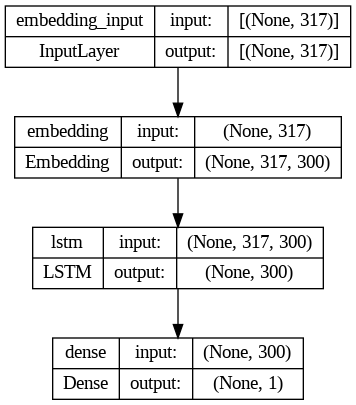

In [ ]:
# Definir el modelo secuencial
model = Sequential()

# Añadir la capa de embedding
model.add(embedding_layer)

# Añadir una capa LSTM con dropout
model.add(LSTM(units=word2vec_model.vector_size, dropout=0.2))

# Añadir la capa de salida, al ser binario usaremos sigmoide
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar la arquitectura del modelo
model.summary()

# Plotear la arquitectura del modelo
plot_model(model, to_file='modelo_rnn.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 317, 300)          1854900   
                                                                 
 lstm_1 (LSTM)               (None, 300)               721200    
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 2576401 (9.83 MB)
Trainable params: 721501 (2.75 MB)
Non-trainable params: 1854900 (7.08 MB)
_________________________________________________________________


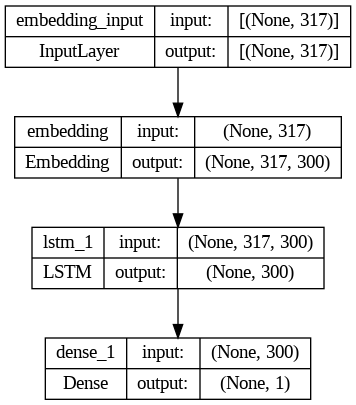

In [ ]:
# Definir el modelo secuencial
model = Sequential()

# Añadir la capa de embedding
model.add(embedding_layer)

# Añadir una capa LSTM con dropout
model.add(LSTM(units=word2vec_model.vector_size, dropout=0.2))

# Añadir la capa de salida con función de activación sigmoide
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar la arquitectura del modelo
model.summary()

# Plotear la arquitectura del modelo
plot_model(model, to_file='modelo_rnn.png', show_shapes=True, show_layer_names=True)

# 6. Entrenamiento y evaluación del clasificador.

In [ ]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

# Evaluación del modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Pérdida en el conjunto de prueba:", loss)
print("Precisión en el conjunto de prueba:", accuracy)

Epoch 1/10
36/36 [==============================] - 6s 48ms/step - loss: 0.6808 - accuracy: 0.5964 - val_loss: 0.6380 - val_accuracy: 0.6797
Epoch 2/10
36/36 [==============================] - 1s 26ms/step - loss: 0.5944 - accuracy: 0.7031 - val_loss: 0.6176 - val_accuracy: 0.6719
Epoch 3/10
36/36 [==============================] - 1s 25ms/step - loss: 0.4820 - accuracy: 0.7691 - val_loss: 0.4428 - val_accuracy: 0.7812
Epoch 4/10
36/36 [==============================] - 1s 24ms/step - loss: 0.4160 - accuracy: 0.8238 - val_loss: 0.3924 - val_accuracy: 0.8359
Epoch 5/10
36/36 [==============================] - 1s 25ms/step - loss: 0.5157 - accuracy: 0.7491 - val_loss: 0.3412 - val_accuracy: 0.8750
Epoch 6/10
36/36 [==============================] - 1s 24ms/step - loss: 0.4215 - accuracy: 0.8177 - val_loss: 0.5027 - val_accuracy: 0.7969
Epoch 7/10
36/36 [==============================] - 1s 25ms/step - loss: 0.4794 - accuracy: 0.8021 - val_loss: 0.4846 - val_accuracy: 0.7656
Epoch 8/10
36

# 7. Conclusiones

Basándonos en los resultados obtenidos del modelo entrenado, podemos sacar las siguientes conclusiones:

1. **Bajo valor de pérdida en el conjunto de prueba (0.1788)**: La pérdida en el conjunto de prueba es una medida de qué tan bien el modelo está haciendo predicciones en datos no vistos. Esto nos indica que el modelo esta haciendo predicciones con precisión y generalizando de buena manera nuestros datos.


2. **Alta precisión en el conjunto de prueba (0.9375)**: La precisión en el conjunto de prueba nos indica la proporción de predicciones correctas realizadas por el modelo en el conjunto de prueba. La precisión es alta (entre más se acerque a uno) nos indica que el modelo está haciendo predicciones con muy buena exactitud en el conjunto de pruebas

3. **Rendimiento general satisfactorio**: Los valores de pérdida bajos y la alta precisión en el conjunto de prueba nos sugieren que el modelo está aprendiendo de manera efectiva y puede realizar predicciones precisas sobre la polaridad de las reseñas de hoteles. Esto implica que la RNN diseñada es capaz de capturar patrones importantes en los datos y generalizar adecuadamente a nuevos ejemplos.

En resumen, el modelo entrenado parece tener un buen rendimiento en la tarea de clasificación de reseñas de hoteles en positivas o negativas, según los valores de pérdida y precisión en el conjunto de prueba proporcionados.

Se anexa [Resumen Ejecutivo](https://docs.google.com/document/d/1SgiJz39CXC9uI6bjGfahKMurwc_aSt_8RlM4argMCBc/edit?usp=sharing) de los hallazgos obtenidos.